# Run all Code Boxes From Here until marked

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math as m
import tifffile
from scipy.spatial import KDTree

import os
import pandas as pd
from sklearn.cluster import DBSCAN
from tkinter import filedialog
from tkinter import Tk

from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [3]:
# Open the TIFF movie
with tifffile.TiffFile('Examples/B1_Composite.tif') as tif:
    # Get the number of frames in the movie
    n_frames = len(tif.pages)

    # Read all frames of the movie and store them as a numpy array
    movie = np.zeros((n_frames, tif.pages[0].shape[0], tif.pages[0].shape[1]), dtype='uint16')
    for i in range(n_frames):
        movie[i,:,:] = tif.pages[i].asarray()

    # Print relevant information about the movie
    print('Number of frames: {}'.format(n_frames))
    print('Shape of each frame: {}'.format(tif.pages[0].shape))
    print('Data type of each pixel: {}'.format(tif.pages[0].dtype))

# Display the first frame of the movie
# plt.figure()
# plt.imshow(movie[0,:,:])
# plt.show()

life_act = movie[0]

Number of frames: 4
Shape of each frame: (2560, 2560)
Data type of each pixel: float32


In [7]:
def locate_homer_centers(path, plot=False):
    # Step 1: Load post-synaptic marker (e.g., Homer, PSD95) ThunderSTORM data
    outputindex = os.path.basename(os.path.dirname(path))
    dim = 2
    picasso = 0  # if Picasso = 1, otherwise = 0
    synapse_size = 50  # cluster size in nm
    min_neighbours = 5  # minimum number of neighbours w/n synapse_size radius for cluster filtering

    root = Tk()
    root.withdraw()
    # file_path = filedialog.askopenfilename(initialdir=path, title="Select the Homer (or synaptic marker) file to process",
    #                                        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
    file_path = r"C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples\B1_aHomer_corrected.csv"

    try:
        ThunderSTORM1 = pd.read_csv(file_path, sep=',', skiprows=1, header=None)
    except Exception:
        ThunderSTORM1 = pd.read_excel(file_path, header=None)

    if picasso == 1:
        ThunderSTORM1.iloc[:, 1] = ThunderSTORM1.iloc[:, 1] + 1

    ThunderSTORM = [ThunderSTORM1.values]
    if dim == 3:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        palmZ = ThunderSTORM[0][:, 4]
        data_Syn = np.column_stack((palmX, palmY, palmZ))
    elif dim == 2:
        palmX = ThunderSTORM[0][:, 2]
        palmY = ThunderSTORM[0][:, 3]
        data_Syn = np.column_stack((palmX, palmY))

    # Finding clusters
    db = DBSCAN(eps=synapse_size, min_samples=min_neighbours, metric='euclidean').fit(data_Syn)
    Class = db.labels_
    type_ = np.array([1 if label != -1 else 0 for label in Class])

    # Make new matrix
    cluster_avgs = []
    if dim == 3:
        Syn = np.column_stack((palmX, palmY, 0.79 * palmZ, Class, type_))
        # Separate and plot clusters
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 3] == k]
                ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], s=20)
    elif dim == 2:
        Syn = np.column_stack((palmX, palmY, Class, type_))
        # Separate and plot clusters
        if plot: plt.figure()

        for k in np.unique(Class):
            if k != -1:
                cluster_points = Syn[Syn[:, 2] == k]
                cluster_avgs.append((sum(cluster_points[:, 0])/len(cluster_points[:, 0]), sum(cluster_points[:, 1])/len(cluster_points[:, 1])))
                if plot: plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20)
    if plot:
        plt.axis('equal')
        # plt.xlim(500, 570)
        # plt.ylim(39530, 39600)
        plt.show()
    return cluster_avgs

In [9]:
path = r'C:\Users\icedn\Jupyter\SelvinLab\Selvin-Lab-qPAINT-Segmentation\Examples'
nm_per_pixel = 21.34
homer_centers_nm = np.array(locate_homer_centers(path))
homer_centers_px = homer_centers_nm/nm_per_pixel
homer_centers_int = homer_centers_px.astype(int)

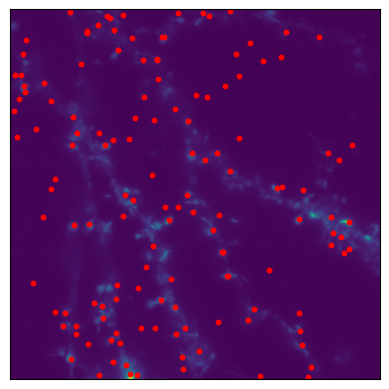

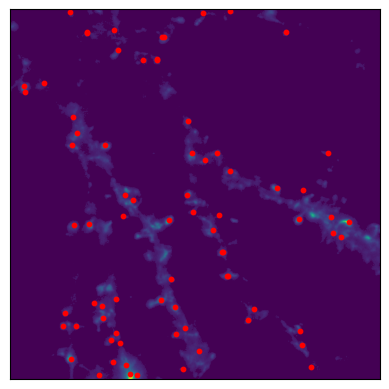

In [102]:
life_act_threshold = 900
plot = True
threshold_map = np.array(life_act > life_act_threshold)
relevant_homer_centers = np.array([homer_centers_px[i] for i in range(len(homer_centers_px)) if threshold_map[homer_centers_int[i][1], homer_centers_int[i][0]]])

if plot:
    plt.figure()
    plt.imshow(life_act, origin='lower')
    plt.scatter(homer_centers_px[:, 0], homer_centers_px[:, 1], s=10, color='r')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()

    plt.figure()
    plt.imshow(life_act*threshold_map, origin='lower')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.scatter(relevant_homer_centers[:, 0], relevant_homer_centers[:, 1], s=10, color='r')
    plt.show()

In [16]:
# read the csv file into a pandas dataframe
GluA1_df = pd.read_csv(r'Examples\B1_GluA1_corrected.csv', delimiter=',')
GluA2_df = pd.read_csv(r'Examples\B1_GluA2_corrected.csv', delimiter=',')

# extract the x and y columns
raw_GluA1_x = GluA1_df['x [nm]']/nm_per_pixel
raw_GluA1_y = GluA1_df['y [nm]']/nm_per_pixel
GluA1_frames = GluA1_df['frame']

# Reshape into points
raw_GluA1_pts = np.array(list(zip(raw_GluA1_x, raw_GluA1_y)))

In [141]:
def find_homer_neighborhood(homer_centers, points, cluster_params):
    eps = cluster_params['eps'] / nm_per_pixel
    min_samples = cluster_params['min_samples']
    radius = cluster_params['radius'] / nm_per_pixel
    kdtree = KDTree(points)
    # workers=-1 is for parallel processing, if running into problems, set to 1
    nearby_point_indices = kdtree.query_ball_point(homer_centers, radius, workers=-1)
    homers_points_and_clusters = []
    for i in range(len(homer_centers)):
        nearby_points = points[nearby_point_indices[i]]
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(nearby_points)
        labels = clustering.labels_
        cluster_points = [nearby_points[labels == i] for i in range(np.max(labels) + 1)]
        cluster_centers = np.array([nearby_points[labels == i].mean(axis=0) for i in range(np.max(labels) + 1)])
        dictionary = {'Homer Center': homer_centers[i], 'Radius': radius, 'Nearby Points': nearby_points,
                      'Cluster Centers': cluster_centers, 'Cluster Points': cluster_points}
        homers_points_and_clusters.append(dictionary)
    return homers_points_and_clusters

In [266]:
class HomerCenter():
    def __init__(self, center, radii=None, points=None, points_label=None, nm_per_pixel=21.34):
        self.center = center
        self.nm_per_pixel = nm_per_pixel
        self.regions = {}
        
        if radii is not None:
            self.add_radii(radii)
            if points_label is None:
                self.points_labels = []
            else:
                self.points_labels = [points_label]
                self.add_points(points, points_label)
        else:
            self.points_labels = []
        return
    
    def add_radii(self, radii):
        if type(radii) != list: radii = [radii]
        for radius in radii:
            self.regions[radius] = {}
        return
    
    def add_points(self, points, points_label):
        if points_label is None:
            if self.points_labels == []:
                raise Exception("No existing labels, \'points_label\' needs to be provided with a string labeling the points")
            else:
                points_label = self.points_labels[0]
                raise Warning(f"No label provided to \'points_label\', assuming points are of label \'{points_label}\'")
        if points_label not in self.points_labels:
            self.points_labels.append(points_label)
        kdtree = KDTree(points)
        for radius in self.regions:
            if points_label not in self.regions[radius]:
                self.regions[radius][points_label] = {}
            points_in_r = points[kdtree.query_ball_point(self.center, radius / self.nm_per_pixel, workers=-1)]
            self.regions[radius][points_label]['points'] = points_in_r
        return

    def find_clusters(self, eps, min_samples, points_label=0):
        if type(points_label) == int:
            points_label = self.points_labels[points_label]
        if type(eps) != list: eps = [eps]
        if type(min_samples) != list: min_samples = [min_samples]
        eps, min_samples = zip(*sorted(zip(eps, min_samples), reverse=True))
        for i in range(len(eps)):
            for radius in self.regions:
                self.regions[radius][points_label]['clustering']= {(eps[i], min_samples[i]): {}}
                nearby_points = self.regions[radius][points_label]['points']
                clustering = DBSCAN(eps=eps[i], min_samples=min_samples[i]).fit(nearby_points)
                labels = clustering.labels_
                for j in range(np.max(labels) + 1):
                    cluster_points = nearby_points[labels == j]
                    cluster_center = cluster_points.mean(axis=0)
                    self.regions[radius][points_label]['clustering'][(eps[i], min_samples[i])][(cluster_center[0], cluster_center[1])] = cluster_points
        return

In [270]:
class FieldOfView():
    def __init__(self, homer_centers, life_act, radii=None, points=None, points_labels=None, threshold=None, nm_per_pixel=21.34):
        self.all_homer_centers = [HomerCenter(homer_center, radii=radii, nm_per_pixel=nm_per_pixel) for homer_center in homer_centers]
        self.life_act = life_act
        self.points = {}
        if points is not None:
            self.add_points(points, points_labels)
        if threshold is None:
            self.active_homers = self.all_homer_centers
        else:
            self.threshold_homers(threshold)
        return
    
    def add_points(self, points, points_labels):
        if type(points_labels) == list:
            for i in range(len(points_labels)):
                self.points[points_labels[i]] = points[i]
        else:
            self.points[points_labels] = points
        return
    
    def add_radii(self, radii):
        for homer in self.all_homer_centers:
            homer.add_radii(radii)
        return
    
    def threshold_homers(self, threshold, plot=False):
        threshold_map = np.array(life_act > threshold)
        hc = [homer.center for homer in self.all_homer_centers]
        hc_passed = np.array([hc[i] for i in range(len(hc)) if threshold_map[int(hc[i][1]), int(hc[i][0])]])
        self.active_homers = [self.all_homer_centers[i] for i in range(len(hc)) if hc[i] in hc_passed]
        
        if plot:
            plt.figure()
            plt.imshow(self.life_act, origin='lower')
            plt.scatter([hc.center[0] for hc in self.all_homer_centers], [hc.center[1] for hc in self.all_homer_centers], s=10, color='r')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()

            plt.figure()
            plt.imshow(self.life_act*threshold_map, origin='lower')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.scatter([hc.center[0] for hc in self.active_homers], [hc.center[1] for hc in self.active_homers], s=10, color='r')
            plt.show()
        return
    
    def find_clusters(self, points_label, eps, min_samples, )

In [273]:
test_FOV = FieldOfView(homer_centers_px, life_act, threshold=900)

In [230]:
def plot_multi_level_clustering(neighborhood, buffer=50, life_act=life_act, all_points=None, scale_bar=True, colors=['yellow', 'orange', 'red']):
    homer_center = neighborhood['Homer Center']
    nearby_points = neighborhood['Nearby Points']
    radius = neighborhood['Radius']
    buffer = buffer + radius
    cluster_points = []
    for i in range(0, int((len(neighborhood)-3)/2)):
        cluster_points.append([list(point) for sublist in neighborhood[f'Cluster Points {i}'] for point in sublist])

    plt.figure(dpi=150)
    plt.imshow(life_act, cmap='magma', origin='lower')
    plt.xlim(homer_center[0] - buffer, homer_center[0] + 1.5*buffer)
    plt.ylim(homer_center[1] - buffer, homer_center[1] + buffer)
    plt.gca().add_artist(plt.Circle(homer_center, radius, fill = False, color='red'))
    if all_points is None:
        plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=0.75, color='white', label=f"All Points")
    else:
        plt.scatter(all_points[:, 0], all_points[:, 1], s=0.75, color='white', label=f"All Points")
    for i in range(len(cluster_points)):
        points = np.array(cluster_points[i])
        if points.shape != (0, ):
            plt.scatter(points[:, 0], points[:, 1], color=colors[i], s=0.75, label=f"Level {i}")
    plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)
        plt.gca().add_artist(scalebar)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.legend()
    for handle in plt.legend().legend_handles:
        handle._sizes = [100]
    plt.show()

In [263]:
test_center = HomerCenter(homer_centers_px[0], [500, 1500], raw_GluA1_pts, 'GluA1')
test_center.find_clusters(80, 10)

In [150]:
def plot_homer_neighborhood(neighborhood, buffer=50, life_act=life_act, scale_bar=True):
    homer_center = neighborhood['Homer Center']
    nearby_points = neighborhood['Nearby Points']
    cluster_centers = neighborhood['Cluster Centers']
    cluster_points = neighborhood['Cluster Points']
    radius = neighborhood['Radius']
    buffer = buffer + radius
    plt.figure(dpi=150)
    plt.imshow(life_act, cmap='magma', origin='lower')
    plt.xlim(homer_center[0] - buffer, homer_center[0] + 1.5*buffer)
    plt.ylim(homer_center[1] - buffer, homer_center[1] + buffer)
    small_circle = plt.Circle(homer_center, radius, fill = False, color='red')
    plt.gca().add_artist(small_circle)
    plt.scatter(nearby_points[:, 0], nearby_points[:, 1], s=0.75, color='white', label=f"All Points")
    for i in range(len(cluster_centers)):
        plt.scatter(cluster_points[i][:, 0], cluster_points[i][:, 1], s=0.75, label=f"Cluster {i}")
        plt.scatter(cluster_centers[i][0], cluster_centers[i][1], marker='x', color='red')
    plt.scatter(homer_center[0], homer_center[1], marker='v', color='chartreuse', s=100, edgecolor='black', label="Homer Center")
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if scale_bar:
        fontprops = fm.FontProperties(size=8)
        scalebar = AnchoredSizeBar(plt.gca().transData,
                                1000/nm_per_pixel,  # length of scale bar
                                '1 micron',  # label
                                'lower right',  # position
                                pad=0.1,
                                color='white',
                                frameon=False,
                                size_vertical=0.05,
                                fontproperties=fontprops)
        plt.gca().add_artist(scalebar)
    plt.legend()
    for handle in plt.legend().legend_handles:
        handle._sizes = [100]
    plt.show()

In [145]:
close_cluster_params = {'eps': 80, 'min_samples': 10, 'radius': 500}
far_cluster_params = {'eps': 80, 'min_samples': 10, 'radius': 1500}

close_homer_neighborhoods = find_homer_neighborhood(relevant_homer_centers, raw_GluA1_pts, close_cluster_params)
far_homer_neighborhoods = find_homer_neighborhood(relevant_homer_centers, raw_GluA1_pts, far_cluster_params)

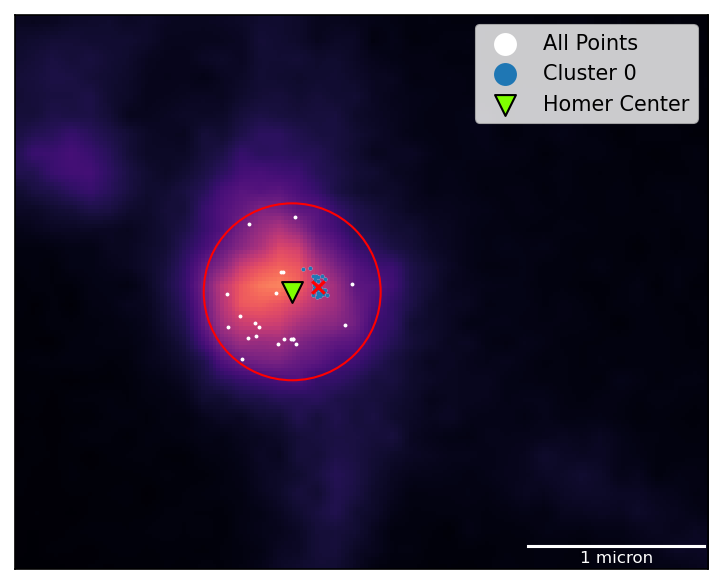

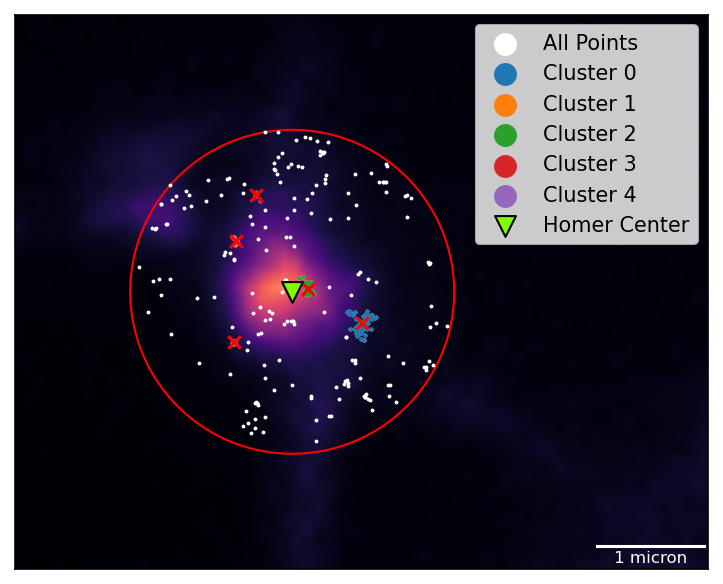

In [151]:
index = 4
plot_homer_neighborhood(close_homer_neighborhoods[index])
plot_homer_neighborhood(far_homer_neighborhoods[index])

In [ ]:
def multi_level_clustering(homer_centers, points, cluster_params):
    neighborhoods = []
    for params in cluster_params:
        neighborhoods.append(find_homer_neighborhood(homer_centers, points, params))
    to_return = []
    for i in range(len(homer_centers)):
        dictionary = {'Homer Center': neighborhoods[0][i]['Homer Center'], 'Radius': neighborhoods[0][i]['Radius'], 'Nearby Points': neighborhoods[0][i]['Nearby Points']}
        for j in range(len(neighborhoods)):
            dictionary[f'Cluster Centers {j}'] = neighborhoods[j][i]['Cluster Centers']
            dictionary[f'Cluster Points {j}'] = neighborhoods[j][i]['Cluster Points']
        to_return.append(dictionary)
    return to_return

In [222]:
cluster_params = [{'eps': 150, 'min_samples': 10, 'radius': 1500},
                  {'eps': 120, 'min_samples': 20, 'radius': 1500},
                  {'eps': 80, 'min_samples': 30, 'radius': 1500}]
multi_level_neighborhoods = multi_level_clustering(relevant_homer_centers, raw_GluA1_pts, cluster_params)

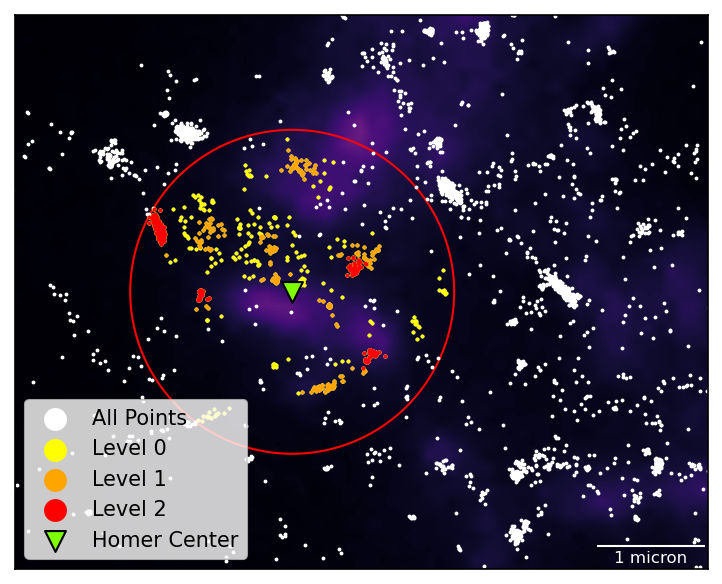

In [231]:
index = 5
plot_multi_level_clustering(multi_level_neighborhoods[index], all_points=raw_GluA1_pts)